# Beachwatch

This notebook examines the bacteria count data for the San Diego coastline, from the Beachwatch program. To analyze beachwatch data, we'll use the data package that is stored on the Library's data repository.

First, visit the [repository home page](http://data.sandiegodata.org) and note the tag for "water-project" below the search box. The [water-project](https://data.sandiegodata.org/dataset?tags=water-project) tag page lists all of the datasets for this project. In the (San Diego Beachwatch Data)[https://data.sandiegodata.org/dataset/ceden-waterboards-ca-gov-beachwatch-sandiego), Look for these to headings, just above the "Data and Resources" section:

- Loading the ZIP Package
- Loading the CSV Package

You can copy the code from one of those sections to get started. 

After opening the data package, we'll look at the results for the stations and station groups, a examine how well readons at one station are correlate with others in the same group. 


## Useful sites

* A great example of [mapping with geopandas](http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/).


In [1]:
import matplotlib.pyplot as plt 
import metapack as mp
import pandas as pd
import numpy as np

# Get the Package

Usually, the first thing you'll do with a Metatab data package is display the top level documentation, to see what resources it has and other basic information


In [2]:
pkg = mp.open_package('http://library.metatab.org/ceden.waterboards.ca.gov-beachwatch-sandiego-2.zip')

pkg

In [3]:
# Displaying a resource gives you the schema. This one isn't complete, since we havent filled in the column descriptions. 
pkg.resource('beachwatch-sd')

Header,Type,Description
program,string,
parentproject,string,
project,string,
stationname,string,
stationcode,string,
sampledate,date,
collectiontime,time,
locationcode,string,
collectiondepth,integer,
unitcollectiondepth,string,


# Open the Resource

Below is another really common pattern. Get the resoruce and extract a Pandas DataFrame, using read_csv(). (You can also use ``.dataframe()``, which has more accurate datatypes, but is slower. ) We'll do some column modifications immediately, then display the data. 

In [4]:
df = pkg.resource('beachwatch-sd').read_csv(parse_dates=True)

# It looks like the prefix of the station code groups stations, maybe into watersheds. 
df['stationgroup'] = df.stationcode.str[:2]

# The results has a large range, so log transformation makes them easier to visualize.
df['log_result'] = df.result.apply(np.log10)

df.head()

,program,parentproject,project,stationname,stationcode,sampledate,collectiontime,locationcode,collectiondepth,unitcollectiondepth,...,huc8,huc8_number,huc10,huc10_number,huc12,huc12_number,waterbody_type,sampleid,stationgroup,log_result
0,BeachWatch,BeachWatch_San Diego County,BeachWatch_San Diego County,"EH-010-Imperial Beach municipal beach, other, ...",EH-010,1999-04-02,2018-07-23,SurfZone,-88,NR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Recorded,EH,5.703782
1,BeachWatch,BeachWatch_San Diego County,BeachWatch_San Diego County,"EH-010-Imperial Beach municipal beach, other, ...",EH-010,1999-04-29,2018-07-23,SurfZone,-88,NR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Recorded,EH,2.995732
2,BeachWatch,BeachWatch_San Diego County,BeachWatch_San Diego County,"EH-010-Imperial Beach municipal beach, other, ...",EH-010,1999-04-30,2018-07-23,SurfZone,-88,NR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Recorded,EH,2.995732
3,BeachWatch,BeachWatch_San Diego County,BeachWatch_San Diego County,"EH-010-Imperial Beach municipal beach, other, ...",EH-010,1999-05-26,2018-07-23,SurfZone,-88,NR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Recorded,EH,2.302585
4,BeachWatch,BeachWatch_San Diego County,BeachWatch_San Diego County,"EH-010-Imperial Beach municipal beach, other, ...",EH-010,1999-05-26,2018-07-23,SurfZone,-88,NR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Recorded,EH,2.995732


In [5]:
df[['stationcode','stationgroup']].drop_duplicates().groupby('stationgroup').count()

,stationcode
stationgroup,
EH,71
EN,5
FM,10
IB,8
MB,46
OC,11
PL,10
SC,2
SE,7


In [6]:
df['stationcode'].value_counts().head()

IB-080    5065
EH-420    4417
FM-010    4150
SE-060    3780
OC-100    3614
Name: stationcode, dtype: int64

In [7]:
df['analyte'].value_counts().head()

Coliform, Total    66992
Coliform, Fecal    65827
Enterococcus       65010
E. coli             4428
Name: analyte, dtype: int64

To ensure that the following comparisions make sense, we'll want to focus on just one type of bacteria count

In [8]:
df = df[df.analyte == 'Coliform, Total']

# Geographic Analysis

The Beachwatch data has position information for the stations, which we will need to match the stations to watersheds. Let's start by looking at their positions on a map. Shapely and Geopandas are the main tools for working with geographic data with Pandas and Jupyter. 


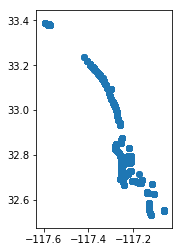

In [9]:
from shapely.geometry import Point
import geopandas as gpd


## Create a new GeoPandas frame, converting the targetlongitude and targetlatitude
## colums to a Shapely Point and assigning it to the frame's geometry

gdf = gpd.GeoDataFrame(df, geometry=
                        [Point(x,y) for x,y in zip(df.targetlongitude, df.targetlatitude)])

# Here is a quick plot
gdf.plot()

## Add a County Outline

The quick graph doesn't have any context for the rest of the county, so let's get another Metatab package with geographic information for the outline of San Diego county. 

In [10]:

## Load a Metapack data package of the US Counties, then extract San Diego county by it's FIPS code, state=6
## county=73 
counties_pkg = mp.open_package('http://library.metatab.org/census.gov-counties-2017-2.csv')

# Use the Metapack feature for turning the Pandas dataframe into a GeoPandas dataframe
counties = counties_pkg.resource('counties').geoframe()

sd_county = counties[(counties.statefp==6) & (counties.countyfp==73) ]

It will be important to verify that the groups of stations are actually geographically close, which is easy to check by coloring each of the groups. The Geopandas ``.plot()`` method has a ``column`` parameter which specifies the colum used to differentiate point colors. 

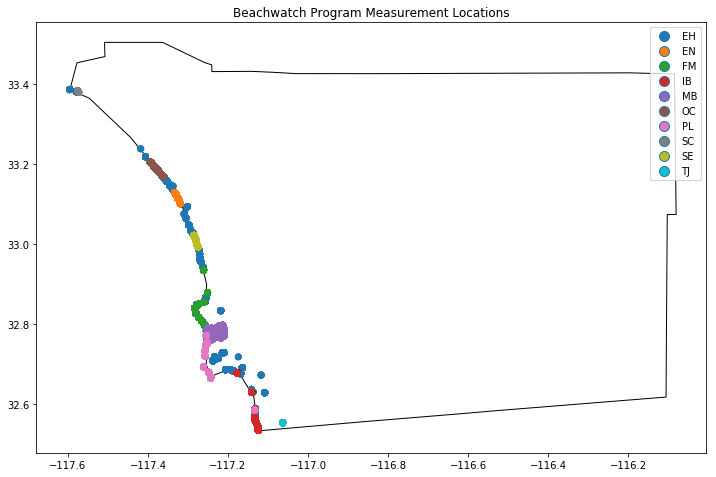

In [11]:
## Plot the county, then use the same Matplotlib axis to plot the points. 
base = sd_county.plot(color='white', edgecolor='black', figsize=(8*1.5,8))
gdf.plot(ax=base,  column='stationgroup', legend=True)
plt.title("Beachwatch Program Measurement Locations")
plt.show()

The 'EH' group seems really spread out, so let's have a closer look at just that group. 


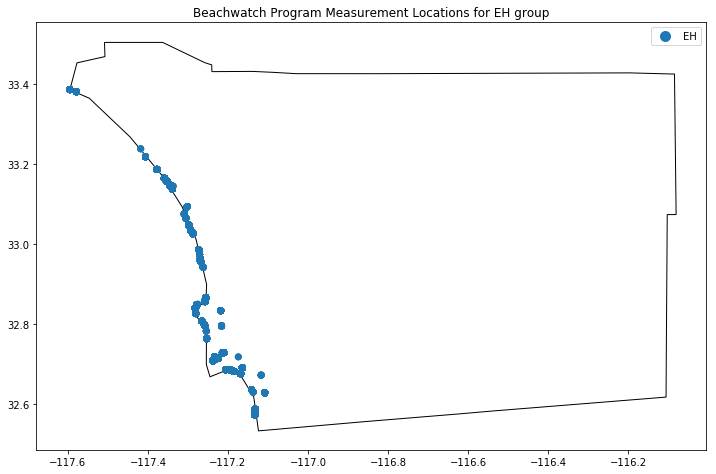

In [12]:
## Plot the county, then use the same Matplotlib axis to plot the points. 
base = sd_county.plot(color='white', edgecolor='black', figsize=(8*1.5,8))
gdf[(gdf.stationgroup == 'EH') ].plot(ax=base,  column='stationgroup', legend=True)
plt.title("Beachwatch Program Measurement Locations for EH group")
plt.show()

The 'EH' group is all over the coast, so the stations in that group probably wont correlate with each other very well. Let's exclude it. 


In [13]:
df = df[df.stationgroup != 'EH']

# Log or Not?

The first of these two plots is bacteria count with the raw ``results`` column. The second uses the log transformed results from ``log_results``


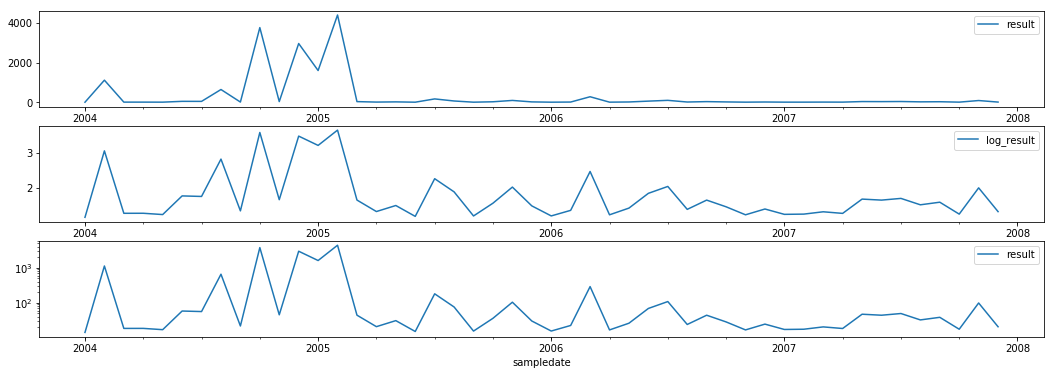

In [34]:
# The results has a large range, so log transformation makes them easier to visualize. These three plots show the original 
# result column, the column plotted with a log scale, and the column plotted with the data log transformed. 
# The really important part here is that the log trasform must be run after the resampling, because adding  values gets a 
# very different result from adding their logs

fig, ax = plt.subplots(3,figsize=(18,6))

_ = df[(df.stationcode=='IB-080') & (df.sampledate.dt.year > 2003) & (df.sampledate.dt.year < 2008)].set_index('sampledate').resample('1m').mean()

# Log transformation myst be applied after resampling. l
_['log_result'] = _.result.apply(np.log10)

_.plot(ax=ax[0], y='result')

ax[2].set_yscale("log", basey=10)
_.plot(ax=ax[2], y='result')

_.plot(ax=ax[1], y='log_result')

# Station group correlations

It is likely that since stations within a group are close to each other, the measures for one group are similar to others in the same group. So, we should try to characterize how well readings between stations in a group are correlated. 

The first way to examine correlations is usually to examine plots, so well create multiple plots, one for each station group to see if it looks like the results vary together.  


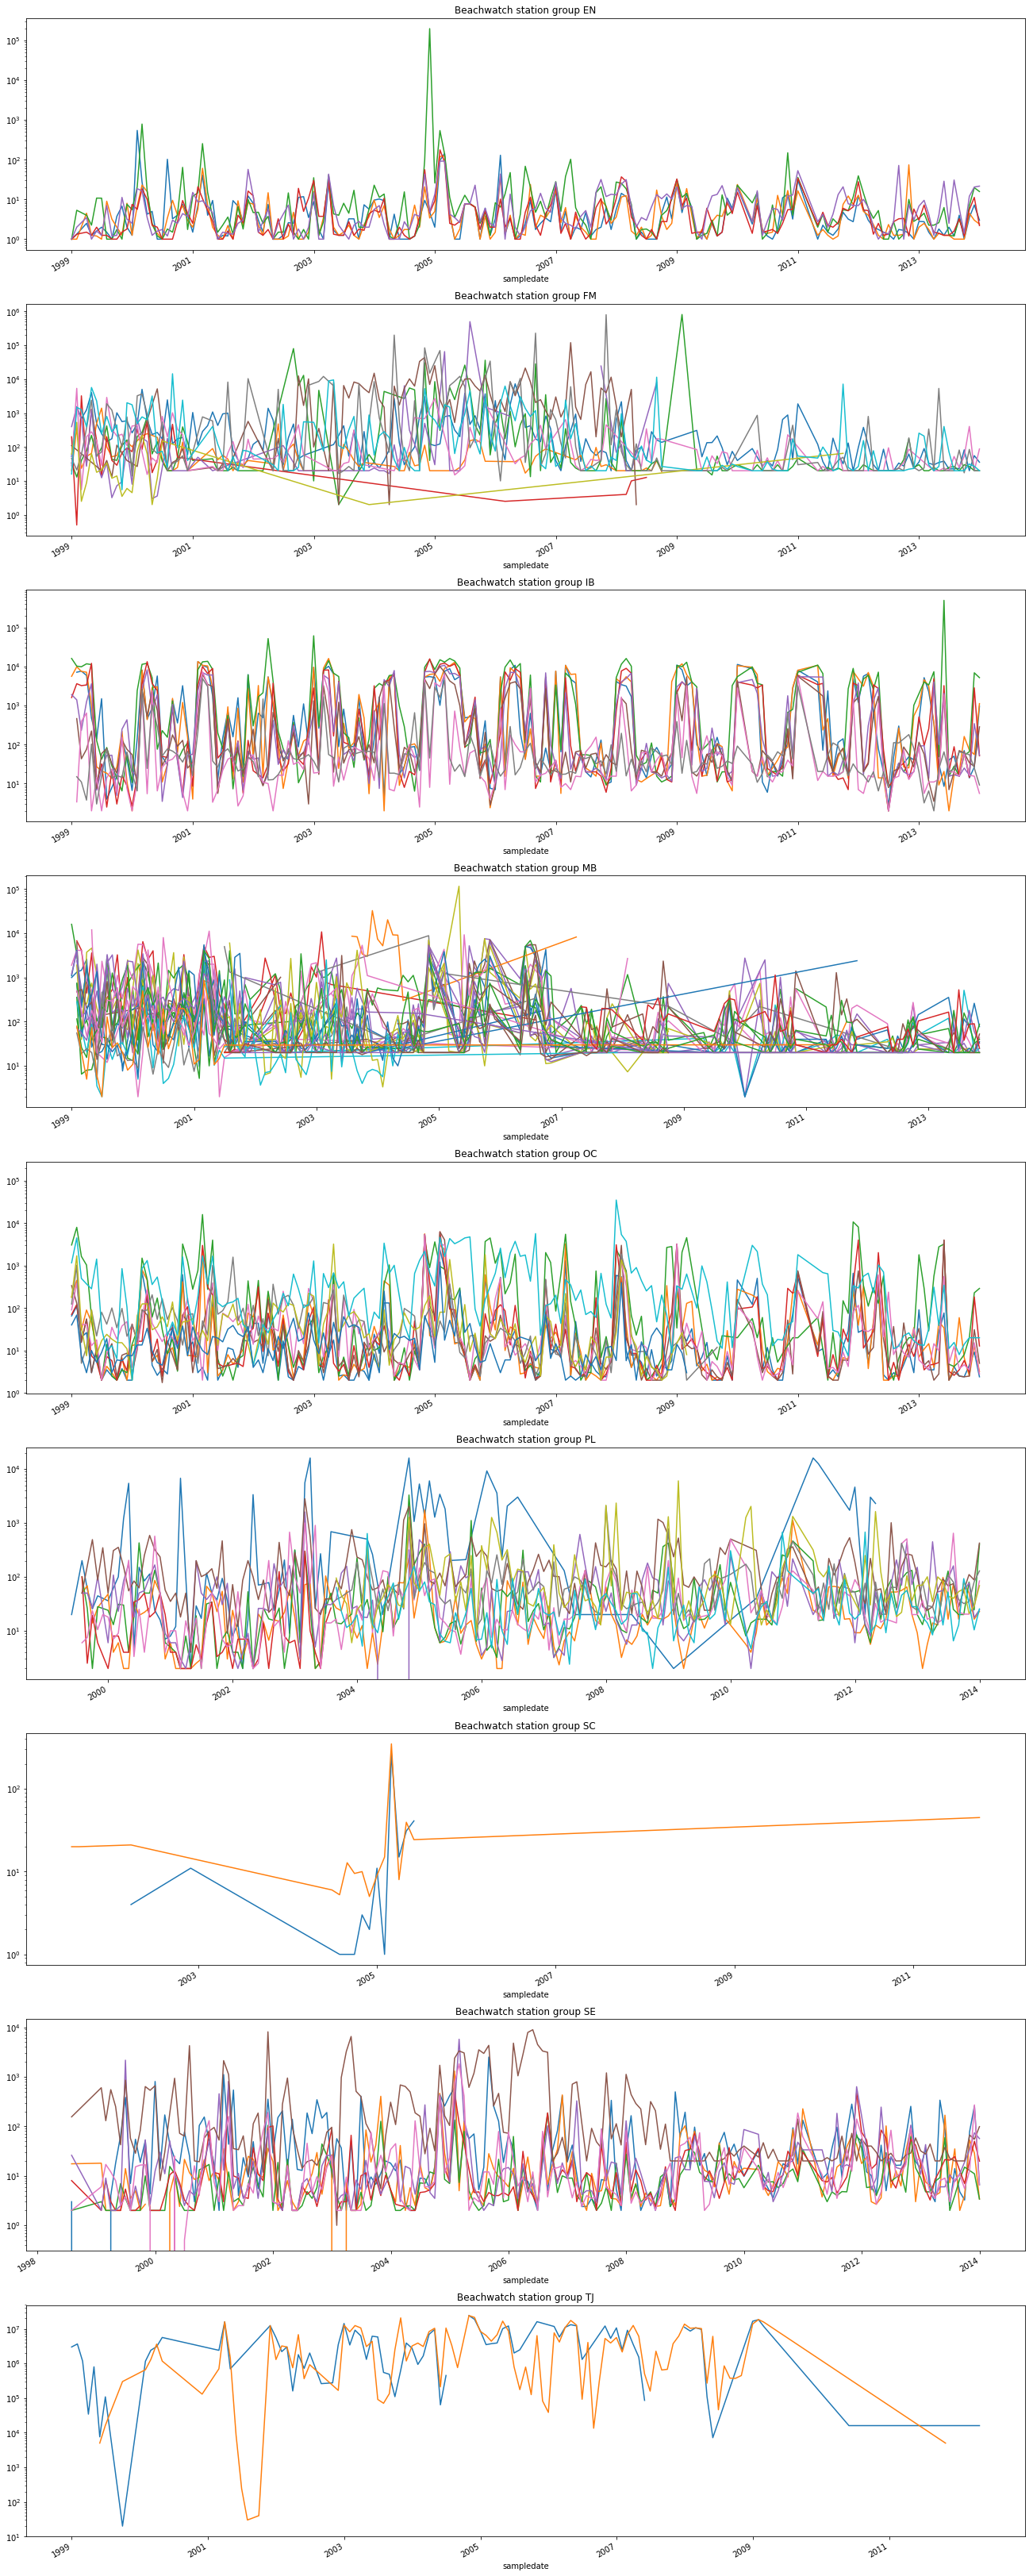

In [38]:
groups = list(df.stationgroup.unique())
fig, axes = plt.subplots(len(groups), 1,figsize=(18,5*len(groups)))

for ax, group in zip(axes, groups):
    
    _ = df[(df.stationgroup==group)]\
        .set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='m')]).mean()
    _['log_result'] = _.result.apply(np.log10)
    _.reset_index().set_index('sampledate').groupby('stationcode').plot(ax=ax,y='result', legend = False)
    ax.set_yscale("log", nonposy='clip')
    ax.set_title("Beachwatch station group {}".format(group))

    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    


In many cases, it looks like they do, although some look like they have less correlation than others. Next, we can try to do quantify the corelation. The Pandas ``.corr()``  method compute correlations for each pair of columns, returning a matrix. For a first attempt, we'll just take the mean of the pairwise correlations. 

In [39]:
from IPython.display import display

def mean_correlation(df, group, column='result'):
    """Build the corelation matrix for all columns, remove the diagonal, and average the remaining values. This uses
    the full matrix, not the triangular matrix, so each value appears twice. """
    
    _ = df[(df.stationgroup==group)]\
            .set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='m')]).mean()
    _['log_result'] = _.result.apply(np.log10)
    _ = _.reset_index().set_index(['stationcode','sampledate'])[column].unstack(level=0)
    corr = _.corr().stack().to_frame()
    corr.columns = [column]
    
    _ = corr[corr[column] < 1.0]

    
    return _.mean().iloc[0]


Should we try to correlat the results, or the log results? Let's try both.

In [40]:
pd.DataFrame([ (group, mean_correlation(df, group,'result') ) for group in groups ]).sort_values(1, ascending=False)
    

,0,1
6,SC,0.992224
8,TJ,0.767448
2,IB,0.461860
4,OC,0.318993
0,EN,0.296907
5,PL,0.266141
7,SE,0.243431
3,MB,0.146339
1,FM,0.075606


In [41]:
pd.DataFrame([ (group, mean_correlation(df, group,'log_result') ) for group in groups ]).sort_values(1, ascending=False)
   

,0,1
6,SC,0.777970
8,TJ,0.588442
0,EN,0.579890
2,IB,0.529375
4,OC,0.450469
7,SE,0.320364
5,PL,0.299003
3,MB,0.200079
1,FM,0.169070


I don' know that it's technical better, but the log results corelation are more like what we'd expect, with strong connections for EN and IB. TJ and SC have few readings on few datasets, so they should be ignored,  but the correlations on the others are stronger for the log results. 


result                                        
stationcode           EN-010    EN-020    EN-030    EN-040    EN-050
       stationcode                                                  
result EN-010       1.000000  0.676336  0.497657  0.663614  0.511541
       EN-020       0.676336  1.000000  0.541813  0.647181  0.603063
       EN-030       0.497657  0.541813  1.000000  0.576943  0.457909
       EN-040       0.663614  0.647181  0.576943  1.000000  0.622845
       EN-050       0.511541  0.603063  0.457909  0.622845  1.000000

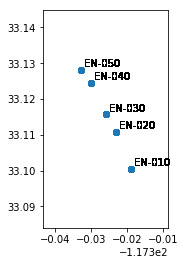

In [62]:

def station_corr_matrix(df, group):
    _ = df[(df.stationgroup==group)].set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='m')]).mean()[['result']]
    _.reset_index().set_index(['stationcode','sampledate'])['result']
    _['result'] = _.result.apply(np.log10)
    return _.unstack(level=0).corr()


def plot_stations_annotated(gdf, group):

    _ = gdf[gdf.stationgroup==group]

    ax = _.plot()

    for x, y, label in zip(_.geometry.x, _.geometry.y, _.stationcode):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

display(station_corr_matrix(df, 'EN'))
plot_stations_annotated(gdf, 'EN')


This is odd; There is a high correlation between ``EN-050`` and ``EN-040``, which is expected because they are next to each other, but ``EN-020`` has a slight negative correlation t0 ``EN-030``, which it is adacent to, but a positive correlation to ``EN-040`` which is farther away. 

result                                          \
stationcode           IB-010    IB-020    IB-030    IB-040    IB-050   
       stationcode                                                     
result IB-010       1.000000  0.911733  0.675791  0.623104  0.579215   
       IB-020       0.911733  1.000000  0.714557  0.692749  0.644016   
       IB-030       0.675791  0.714557  1.000000  0.801996  0.732612   
       IB-040       0.623104  0.692749  0.801996  1.000000  0.917109   
       IB-050       0.579215  0.644016  0.732612  0.917109  1.000000   
       IB-060       0.498883  0.554977  0.583664  0.740512  0.765652   
       IB-070       0.293198  0.320058  0.349053  0.431195  0.434087   
       IB-080       0.157300  0.158338  0.103772  0.247835  0.296353   

                                                  
stationcode           IB-060    IB-070    IB-080  
       stationcode                                
result IB-010       0.498883  0.293198  0.157300  
       IB-020       0.554977  0.320058  0.158338  
       IB-030       0.583664  0.349053  0.103772  
       IB-040       0.740512  0.431195  0.247835  
       IB-050       0.765652  0.434087  0.296353  
       IB-060       1.000000  0.583160  0.435674  
       IB-070       0.583160  1.000000  0.575917  
       IB-080       0.435674  0.575917  1.000000

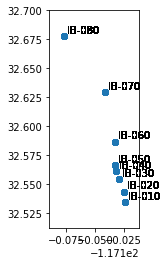

In [63]:
display(station_corr_matrix(df, 'IB'))
plot_stations_annotated(gdf, 'IB')

The IB correlations look more sensible. ``IB-070`` and ``IB-080`` have a strong correlation with each other, but not the rest, since they are farther away. The more southern stations are strongly correlated with each other. 

# Next Steps

This analysis provides some guidance for future analysis. Conclusions include: 

- We should probably analyze log results, rather than just results. 
- Stations that are close to each other are likely to have correlated results. We might be able to create composite measurements from groups of stations. 

Questions we should answer with addtional analysis: 

- What watersheds are the station groups in? Are all stations in one group in the same watershed?
- What creeks are the stations near?
- How do results correlate to rainfall?
- How do results correlate to creek flow. 
